In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
from scipy import signal
import os
from collections import Counter
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
# os.environ["MP_DUPLICATE_LIB_OK"] = "True"

## Call model

In [24]:
class lstm_linear(nn.Module):
    def __init__(self,chunk =10,sigmoid_state=True,len_input = 16,outputa = 50):
        super().__init__()
        
        h_ = 128
        
        self.dropout = nn.Dropout(p=0.3)
        self.biLSTM = nn.LSTM(chunk,h_,bidirectional=True)
        self.linear1 = nn.Linear((h_ * 2 * len_input),128)
        # self.linear2 = nn.Linear(128,128)
        self.Lazyl1 = nn.LazyLinear(128)
        self.linear2 = nn.Linear(128,outputa)
        self.sigmoid  = nn.Sigmoid()
        self.softmax  = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.sigmoid_state = sigmoid_state
    def forward(self,x):
        
        out1,(hn,cn) = self.biLSTM(x)
        
        # print(out1.size())
        b,f,o = out1.size()
        # out1 = out1.flatten()
        
        out1 = out1.reshape(b,-1)
        
        output = self.linear1(self.relu(out1))
        # output = self.linear2(self.relu(output))
        y_final = self.linear2(self.relu(output))
        
        # if self.sigmoid_state:
        #     y_final = self.sigmoid(y_final)
        # else:
        #     y_final = self.softmax(y_final)

        return y_final

class cnn_lstm(nn.Module):
    def __init__(self,chunk =10,sigmoid_state=True,len_input = 16,outputa = 50):
        super().__init__()
        
        h_ = 128
        
        # self.conv2d1 = nn.Conv2d(1,32,kernel_size=(3,3))
        # self.conv2d2 = nn.Conv2d(32,64,kernel_size=(3,3))
        # self.conv2d3 = nn.Conv2d(64,64,kernel_size=(3,3))
        h1, w1 = chunk // 2, len_input // 2
        h2, w2 = h1 // 2, w1 // 2
        h3, w3 = h2, w2
        
        
        
        
        self.normalization = nn.BatchNorm1d(len_input)
        self.conv2d1 = nn.Conv2d(1,32,kernel_size=(3,3),padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2d2 = nn.Conv2d(32,64,kernel_size=(3,3),padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2d3 = nn.Conv2d(64,128,kernel_size=(3,3),padding=1)
        self.relu = nn.ReLU()
        # self.lstm = nn.LSTM(12*7,256)
        
        self.linear1 = nn.Linear(128*h3*w3,64)
        self.linear2 = nn.Linear(64,outputa)
        
    def forward(self,x):
        
        batch_size = x.size(0)
        
        # Normalize along feature dimension
        # Reshape for BatchNorm1d: (batch_size * seq_len, n_features)
        x_norm = x.view(-1, x.size(2))
        x_norm = self.normalization(x_norm)
        x = x_norm.view(batch_size, x.size(1), x.size(2))
        
        # out1 = self.batch_norm(x)
        
        out1 = x.unsqueeze(1)
        # print(out1)
        out1 = self.conv2d1(out1)
        out1 = self.maxpool1(out1)
        out1 = self.relu(out1)
        
        out1 = self.conv2d2(out1)
        out1 = self.maxpool2(out1)
        out1 = self.relu(out1)
        
        out1 = self.conv2d3(out1)
        out1 = self.relu(out1)
        
        out1 = out1.view(batch_size, -1)
         
        out = self.linear1(out1)                        
        out = self.linear2(out)                             
        # if self.sigmoid_state:
        #     y_final = self.sigmoid(y_final)
        # else:
        #     y_final = self.softmax(y_final)

        return out

class CNNTimeSeriesClassifier(nn.Module):
    def __init__(self, input_shape, n_classes, dropout=0.3):
        """
        CNN-based Time Series Classifier following your architecture diagram
        
        Args:
            input_shape: Tuple (sequence_length, n_features) - e.g., (121, 21)
            n_classes: Number of output classes
            dropout: Dropout rate
        """
        super(CNNTimeSeriesClassifier, self).__init__()
        
        seq_len, n_features = input_shape
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.dropout_rate = dropout
        
        # Input normalization layer
        self.normalization = nn.BatchNorm1d(n_features)
        
        # Reshape for 2D convolution: (batch, channels, height, width)
        # We'll treat sequence as height and features as width, with 1 channel
        # Input shape: (None, 1, seq_len, n_features) - e.g., (None, 1, 121, 21)
        # First Conv2D block
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after first conv+pool
        # After conv1: (None, 32, 121, 21) -> (None, 32, 119, 19) with padding=1
        # After pool1: (None, 32, 119, 19) -> (None, 32, 59, 9)
        h1, w1 = seq_len // 2, n_features // 2
        
        # Second Conv2D block
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after second conv+pool
        # After conv2: (None, 64, 59, 9) -> (None, 64, 57, 7) with padding=1
        # After pool2: (None, 64, 57, 7) -> (None, 64, 28, 3)
        h2, w2 = h1 // 2, w1 // 2
        
        # Third Conv2D block
        self.conv3 = nn.Conv2d(
            in_channels=64, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        
        # Calculate final conv output shape
        # After conv3: (None, 64, 28, 3) -> (None, 64, 26, 1) with padding=1
        h3, w3 = h2, w2
        
        # Calculate flattened size dynamically
        self.flatten_size = 64 * h3 * w3
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, n_classes)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights properly"""
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        # Input shape: (batch_size, seq_len, n_features)
        batch_size = x.size(0)
        
        # Normalize along feature dimension
        # Reshape for BatchNorm1d: (batch_size * seq_len, n_features)
        x_norm = x.view(-1, x.size(2))
        x_norm = self.normalization(x_norm)
        x = x_norm.view(batch_size, x.size(1), x.size(2))
        
        # Reshape for 2D convolution: (batch_size, 1, seq_len, n_features)
        x = x.unsqueeze(1)
        
        # First Conv2D + MaxPool2D
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Conv2D + MaxPool2D
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Third Conv2D
        x = self.conv3(x)
        x = self.relu(x)
        
        # Flatten
        x = x.view(batch_size, -1)
        
        # First Dense layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second Dense layer (output)
        x = self.fc2(x)
        
        return x
    
    def get_config(self):
        """Return model configuration for saving"""
        return {
            'input_shape': self.input_shape,
            'n_classes': self.n_classes,
            'dropout': self.dropout_rate,
            'flatten_size': self.flatten_size
        }

    
class CustomDataset(Dataset):
    def __init__(self,
                 csv_path,
                 batch=16,
                 chunk = 100,
                 vocab_path = "../Sign_Language_Detection/label.json",
                table:bool = False,
                dataframe=None):
        
        
        with open(vocab_path,"r") as f:
            compare = json.load(f)
        self.vocab = len(compare)
        
        if not table:
            self._data_csv = pd.read_csv(csv_path)
        else:
            self._data_csv = dataframe
        
        
        self._data_csv = self._data_csv[~(self._data_csv.Label.isin([ "cooldown","error_redo","break_time",]))]
        self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])
        self._data_csv = self._data_csv.drop(columns=["timestamp_ms"])
        self.train_data = self.convert_data_csv_train(self._data_csv,compare,segment=chunk,range_data=25)
        # print(len(self.train_data))
        
        print(self.train_data.size())
        fity = []
        normal =[]
        for i in self.train_data:
            # print(i[:,-1][0])
            if int(i[:,-1][-1]) == 0:
                fity.append(i)
            else:
                normal.append(i)
        # print(len(fity))
        # print(len(normal))
        fity = random.sample(fity,int(len(fity) * 0.5))
        normal.extend(fity)
        self.train_data = normal
        self.nums  = len(self.train_data)
        self.answer_transform = []
    
        self.train_data = torch.tensor([i.tolist() for i in self.train_data])
        
        
        for i in range(0,len(self.train_data)):
            # print(self.train_data)
            
            
            dummy = torch.zeros(self.vocab)
            ct = Counter(self.train_data[i][:,-1].tolist()).most_common()
            if len(ct) == 2 and ct[0][0] ==0:
                idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[1]
            else:
                idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[0]
            # print(Counter(self.train_data[i][:,-1].tolist()).most_common())

            dummy[int(idx)] = 1
            self.answer_transform.append(dummy)
        
        self.train_data = self.train_data[:,:,:-1]
        self.nums,self.segment,self.input = self.train_data.size()
        
        
    def __getitem__(self, index):
        
        inputs = self.train_data[index]
        answer = self.answer_transform[index]
        
        if torch.cuda.is_available():
            return inputs.to(torch.float32).to("cuda"),answer.to("cuda")
        else:
            return inputs.to(torch.float32),answer
        
        
    def __len__(self):
        return self.nums
    
    def len_answer(self):
        return self.vocab
    
    def data_info(self):
        return self.nums,self.segment,self.input,self.train_data
    
    
    
    def convert_data_csv_train(self,data,compare,segment=50,range_data = 0):

        datta = []
        previous = None
        samples = []
        abc= []
        
        
        data['group_id'] = (data['Label'] != data['Label'].shift()).cumsum()
        grouped_dfs = [g.drop(columns='group_id').values for _, g in data.groupby('group_id')]
        
        
        
        print("len(data): ",len(grouped_dfs))
        print("filter Value")
        all_data = []
        for i in tqdm(grouped_dfs,total = len(grouped_dfs)):
            if len(i) > range_data:
                all_data.append(i)


        print("pad&mean Value")

        real = []
        for i in tqdm(all_data,total = len(all_data)):
            segment = segment
            if len(i) < segment:
                tensor_df = (torch.tensor(i))
                n,b = tensor_df.size()
                padded_tensor = torch.nn.functional.pad(tensor_df, pad=(0, 0, 0,segment-n), mode='constant', value=0)
                # print(padded_tensor.size())
                real.append(padded_tensor.tolist())
            else:
                step = int(np.ceil(len(i)//segment))
                temp = []
                for k in range(segment):
                    temp.append(torch.mean(torch.tensor(i[k*step:(k+1)*step]),dim=0).tolist())
                real.append(temp)
                
                
                
                

        train_data = torch.tensor(real)
        return train_data
    
class ImprovedCustomDataset(Dataset):
    def __init__(self, dataframe, chunk_size=121, label_encoder=None, is_test=False, 
                 balance_classes=False, min_sequence_length=50,zero_ratio=1,down_zero=True):
        """
        Improved dataset class for CNN time series classification
        
        Args:
            dataframe: Input dataframe
            chunk_size: Sequence length for time series (121 to match your diagram)
            label_encoder: Pre-fitted label encoder (for test data)
            is_test: Whether this is test data
            balance_classes: Whether to balance classes
            min_sequence_length: Minimum sequence length to keep
        """
        self.chunk_size = chunk_size
        self.min_sequence_length = min_sequence_length
        
        # Clean data
        self.data = dataframe.copy()
        self.data = self.data[~self.data.Label.isin(["cooldown", "error_redo", "break_time"])]
        
        # Handle label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.data["Label"] = self.label_encoder.fit_transform(self.data["Label"])
        else:
            self.label_encoder = label_encoder
            # Handle unseen labels in test data
            known_labels = set(label_encoder.classes_)
            mask = self.data["Label"].isin(known_labels)
            if not mask.all():
                print(f"Warning: Removing {(~mask).sum()} samples with unknown labels")
                self.data = self.data[mask]
            self.data["Label"] = label_encoder.transform(self.data["Label"])
        
        self.n_classes = len(self.label_encoder.classes_)
        
        # Remove timestamp if present
        if "timestamp_ms" in self.data.columns:
            self.data = self.data.drop(columns=["timestamp_ms"])
        
        # Convert to sequences
        self.sequences, self.labels = self._create_sequences()
        
        # Balance classes if requested and not test data
        if balance_classes and not is_test:
            self.sequences, self.labels = self._balance_classes()
        
        if down_zero and not is_test:
            self.sequences, self.labels = self._down_zero(zero_ratio = zero_ratio)
            
        
        print(f"Dataset created: {len(self.sequences)} sequences of shape {self.sequences.shape}")
        print(f"Classes: {self.n_classes}, Distribution: {Counter(self.labels.numpy())}")
    
    def _create_sequences(self):
        """Create sequences from grouped data"""
        # Group by consecutive labels
        self.data['group_id'] = (self.data['Label'] != self.data['Label'].shift()).cumsum()
        grouped_data = [group.drop('group_id', axis=1) for _, group in self.data.groupby('group_id')]
        
        print(f"Found {len(grouped_data)} label groups")
        
        # Filter by minimum length
        valid_groups = [group for group in grouped_data if len(group) >= self.min_sequence_length]
        print(f"Kept {len(valid_groups)} groups after length filtering")
        
        sequences = []
        labels = []
        
        for group in tqdm(valid_groups, desc="Processing sequences"):
            # Separate features and labels
            features = group.drop('Label', axis=1).values
            group_labels = group['Label'].values
            
            # Get the most common label in the sequence
            most_common_label = Counter(group_labels).most_common(1)[0][0]
            
            # Create fixed-length sequence
            if len(features) >= self.chunk_size:
                # If longer than chunk_size, use uniform sampling
                indices = np.linspace(0, len(features)-1, self.chunk_size, dtype=int)
                sequence = features[indices]
            else:
                # If shorter, pad with zeros at the end
                sequence = np.zeros((self.chunk_size, features.shape[1]))
                sequence[:len(features)] = features
            
            sequences.append(sequence)
            labels.append(most_common_label)
        
        return torch.FloatTensor(sequences), torch.LongTensor(labels)
    
    def _balance_classes(self):
        """Balance classes by undersampling majority classes"""
        # Get class counts
        unique_labels, counts = torch.unique(self.labels, return_counts=True)

        min_count = counts.min().item()
        
        print(f"Balancing classes to {min_count} samples each")
        
        balanced_sequences = []
        balanced_labels = []
        
        for label,counts in zip(unique_labels,counts):
            # Get indices for this class
            class_indices = (self.labels == label).nonzero(as_tuple=True)[0]
            # Sample min_count indices
            # if len(class_indices) > min_count and label.item() == 0:
            #     sampled_indices = class_indices[torch.randperm(len(class_indices))[:int(counts.item() * zero_ratio )]]
            if len(class_indices) > min_count:
                sampled_indices = class_indices[torch.randperm(len(class_indices))[:min_count]]
            else:
                sampled_indices = class_indices
            
            balanced_sequences.append(self.sequences[sampled_indices])
            balanced_labels.append(self.labels[sampled_indices])
        
        return torch.cat(balanced_sequences), torch.cat(balanced_labels)
    
    def _down_zero(self,zero_ratio = 1):
        """Balance classes by undersampling majority classes"""
        # Get class counts
        unique_labels, counts = torch.unique(self.labels, return_counts=True)

        
        print(f"down zero with {zero_ratio} ratio")
        
        balanced_sequences = []
        balanced_labels = []
        
        for label,counts in zip(unique_labels,counts):
            # Get indices for this class
            class_indices = (self.labels == label).nonzero(as_tuple=True)[0]
            # Sample min_count indices
            if label.item() == 0:
                sampled_indices = class_indices[torch.randperm(len(class_indices))[:int(counts.item() * zero_ratio )]]
            else:
                sampled_indices = class_indices
            
            balanced_sequences.append(self.sequences[sampled_indices])
            balanced_labels.append(self.labels[sampled_indices])
        
        return torch.cat(balanced_sequences), torch.cat(balanced_labels)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]
    
    def get_info(self):
        """Return dataset information"""
        return {
            'n_samples': len(self.sequences),
            'sequence_length': self.chunk_size,
            'n_features': self.sequences.shape[2],
            'n_classes': self.n_classes,
            'label_encoder': self.label_encoder,
            'class_names': self.label_encoder.classes_,
            'input_shape': (self.chunk_size, self.sequences.shape[2])
        }


## Train

In [5]:
dat = r"""data\2025-06-24\data\20250624_081243_test01_sensor.csv
data\2025-06-24\data\20250624_084604_session_sensor.csv
data\2025-06-24\data\20250624_091423_session_sensor.csv
data\2025-06-24\data\20250624_091650_กองภพ24062025_sensor.csv
data\2025-06-24\data\20250624_101902_ชาตชาย24062025_sensor.csv
data\2025-06-24\data\20250624_131408_พชชาภา24062025_sensor.csv
data\2025-06-24\data\20250624_152920_ภรณภทร24062_sensor.csv
data\8-7-2025\data\20250708_130659_Fahsai_ทหลง2_sensor.csv
data\8-7-2025\data\20250708_131357_Fahsai_ทน2_sensor.csv
data\8-7-2025\data\20250708_131831_Fahsai_ทนน2_sensor.csv
data\8-7-2025\data\20250708_132327_Fahsai_คำถาม2_sensor.csv 
data\8-7-2025\data\20250708_133838_Fahsai_รอ_sensor.csv
data\Data 7-7-2025\data\20250707_131551_Fahsai_ใหญ_sensor.csv
data\Data 7-7-2025\data\20250707_132015_Fahsai_เลก_sensor.csv
data\Data 7-7-2025\data\20250707_132533_Fahsai_รอน_sensor.csv
data\Data 7-7-2025\data\20250707_133524_Fahsai_วนน_sensor.csv
data\Data 7-7-2025\data\20250707_134251_Fahsai_พรงน_sensor.csv
data\Data 7-7-2025\data\20250707_134758_Fahsai_เมอวาน_sensor.csv
data\Data 7-7-2025\data\20250707_144852_Fahsai_บาน2_sensor.csv
data\Data 7-7-2025\data\20250707_145353_Fahsai_โรงเรยน_sensor.csv
data\Data 7-7-2025\data\20250707_154934_Fahsai_หนงสอ_sensor.csv
data\Data 7-7-2025\data\20250707_155036_Fahsai_หนงสอ2_sensor.csv
 data\Data 7-7-2025\data\20250707_163136_Fahsai_ทหลง_sensor.csv"""
dat = dat.split("\n")
not_include = [i.split("\\")[-1]  for i in dat]

In [116]:
import glob
import os

base_df = pd.DataFrame()
# for i in glob.glob(r"./collect_data/new_data/*"):
    # if i.split("\\")[-1] not in not_include:
df = pd.read_csv(r"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\normal_train_data.csv")
base_df = pd.concat([base_df,df])   
print(len(base_df))


596008


In [108]:
# train_dataset = CustomDataset("collect_data/20250624_101902_ชาตชาย24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=50,table=True,dataframe=base_df)
# data_answer = []
# for inputs,answer in tqdm(train_dataset):
      
      # try:
          # print(torch.tensor(inputs[i:i+chunk]).size())
    #   data_answer.append(answer)


# train.size()

# with open("rollback.json",'r') as f:
#     ct = json.load(f)
    
    
# print(len(data_answer))
# label_list = [int(torch.argmax(i)) for i in data_answer] 
# nv = Counter(label_list)
# print(nv.most_common())



# not_eng = []
# for i,v in nv.most_common():
#     print(f"{ct[str(i)]} : {v} ")

In [117]:


epoch = 100
lr = 2e-3
chunk = 50
e = 0
best_loss = 0
path_save = "../Sign_Language_Detection/model/Version1"
num_still = 0
sigoid_state = False
batch_size = 128

train_dataset = CustomDataset("collect_data/20250624_101902_ชาตชาย24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=chunk,table=True,dataframe=base_df)


len_output = train_dataset.len_answer()
len_input = train_dataset.data_info()[-2]
train_dataset = DataLoader(train_dataset,batch_size=batch_size)

# if torch.cuda.is_available():
#   lstm = cnn_lstm(chunk,sigmoid_state=sigoid_state,len_input=len_input,outputa=len_output).to("cuda")
# else:
#   lstm = cnn_lstm(chunk,sigmoid_state=sigoid_state,len_input=len_input,outputa=len_output)

if torch.cuda.is_available():
  lstm = CNNTimeSeriesClassifier((chunk,len_input),len_output,dropout=0.4).to("cuda")
else:
  lstm = CNNTimeSeriesClassifier((chunk,len_input),len_output,dropout=0.4)
# patch_len = 10
# stride = 10
# d_model = 64
# hidden_dim = 128

# lstm = PLSTM(len_input, patch_len, stride, d_model, hidden_dim, len_output)



optimizer = torch.optim.AdamW(lstm.parameters(),lr=lr,weight_decay=0.0001)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min',patience =3  ,min_lr = 5e-6,factor=0.5)
print(f" data train = {int(len(train_dataset)*batch_size)} with {len_input} feature")


n = 0
for param in lstm.parameters():
  param.requires_grad=True
lstm.train()

for k in range(1,epoch+1):
    loss_total = 0
    data_answer = []
    for inputs,answer in tqdm(train_dataset):
      # answer = answer[0]
      data_answer.append(answer)
      output = lstm(inputs)
      optimizer.zero_grad()
      if torch.argmax(answer).item() != torch.argmax(output).item():
        loss = criterion(output,answer)
      else:
        loss = criterion(output,answer)
      
      
      loss.backward()

      optimizer.step()

      loss_total += loss
      n+=1
        
    if best_loss == 0 or best_loss > loss_total/len(train_dataset):
      best_loss = loss_total/len(train_dataset)
      state_dict = lstm.state_dict()
      e = k
      num_still = 0
    else:
      num_still +=1
      
    scheduler.step(loss_total/len(train_dataset))
    num_still = 0
    if num_still >= 3:
      print("step up to learning = ",scheduler.get_last_lr())
      break
  
  
    if k% 10==0 and k!=0:
      import glob
      import os



      test_df = pd.read_csv(rf"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\20250715_111750_DATA_INDICATOR_sensor.csv")
      # test_df  = test_df[test_df.columns[1:]]
      test_dataset = CustomDataset("collect_data/20250624_131408_พชชาภา24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=chunk,table=True,dataframe=test_df)
      test_dataset = DataLoader(test_dataset,batch_size=1)

      y_pred = []
      y_true = []
      prob_x = []
      prob_y = []
      with torch.no_grad():
          for inputs,answer in tqdm(test_dataset):
              output = lstm(inputs)
              prob_x.append(output)
              prob_y.append(answer)
              y_pred += (torch.argmax(output,dim=1)).tolist()
              y_true += (torch.argmax(answer,dim=1)).tolist()
                  
                
      from sklearn.metrics import f1_score,recall_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
      f1_scores = f1_score(y_true, y_pred, average="micro")
      print("f1 score    ",f1_scores)
      recall_scores = recall_score(y_true, y_pred, average="micro")
      print("recal score ",recall_scores)
      acc = accuracy_score(y_true, y_pred)
      print("acc score   ",acc)
      # cnf = confusion_matrix(y_true, y_pred)  
    
      
    
    print(f"epoch number {k} loss = {loss_total/len(train_dataset)} with lr = {scheduler.get_last_lr()}")
print(f"best loss at epoch = {e} with {best_loss}")
torch.save(state_dict,f"{path_save}/model_epoch_{e}_croc.pt")
torch.save(lstm, r"./model/Version1/finalmodel_croc.pt")


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


len(data):  9669
filter Value


  0%|          | 0/9669 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/4986 [00:00<?, ?it/s]

torch.Size([4986, 50, 29])
 data train = 4992 with 28 feature


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 1 loss = 3.966810941696167 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 2 loss = 3.5274884700775146 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 3 loss = 3.040966272354126 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 4 loss = 2.638681173324585 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 5 loss = 2.269826650619507 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 6 loss = 1.944569706916809 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 7 loss = 1.6930173635482788 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 8 loss = 1.5073882341384888 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 9 loss = 1.3252522945404053 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.08256880733944955
recal score  0.08256880733944955
acc score    0.08256880733944955
epoch number 10 loss = 1.190516710281372 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 11 loss = 1.0761864185333252 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 12 loss = 1.0038971900939941 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 13 loss = 0.8945263624191284 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 14 loss = 0.8171292543411255 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 15 loss = 0.7471691370010376 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 16 loss = 0.7157631516456604 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 17 loss = 0.6234520673751831 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 18 loss = 0.564498782157898 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 19 loss = 0.5578475594520569 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.22935779816513763
recal score  0.22935779816513763
acc score    0.22935779816513763
epoch number 20 loss = 0.5265121459960938 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 21 loss = 0.5198546648025513 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 22 loss = 0.46611467003822327 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 23 loss = 0.4517858326435089 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 24 loss = 0.43720901012420654 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 25 loss = 0.43327298760414124 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 26 loss = 0.41580185294151306 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 27 loss = 0.37701570987701416 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 28 loss = 0.3548657298088074 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 29 loss = 0.35193535685539246 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.22018348623853212
recal score  0.22018348623853212
acc score    0.22018348623853212
epoch number 30 loss = 0.32058191299438477 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 31 loss = 0.3302856385707855 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 32 loss = 0.3028872311115265 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 33 loss = 0.2959426939487457 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 34 loss = 0.3030009865760803 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 35 loss = 0.31001606583595276 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 36 loss = 0.2902292013168335 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 37 loss = 0.25565260648727417 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 38 loss = 0.23614491522312164 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 39 loss = 0.23578020930290222 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.24770642201834864
recal score  0.24770642201834864
acc score    0.24770642201834864
epoch number 40 loss = 0.21965213119983673 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 41 loss = 0.23156891763210297 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 42 loss = 0.20375221967697144 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 43 loss = 0.2219984084367752 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 44 loss = 0.23129262030124664 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 45 loss = 0.22519667446613312 with lr = [0.002]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 46 loss = 0.2086806446313858 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 47 loss = 0.18307188153266907 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 48 loss = 0.15982691943645477 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 49 loss = 0.14121070504188538 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.26605504587155965
recal score  0.26605504587155965
acc score    0.26605504587155965
epoch number 50 loss = 0.14375536143779755 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 51 loss = 0.1402113437652588 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 52 loss = 0.1456553190946579 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 53 loss = 0.13138258457183838 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 54 loss = 0.11326856911182404 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 55 loss = 0.12183330208063126 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 56 loss = 0.1335737109184265 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 57 loss = 0.1300954818725586 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 58 loss = 0.1086534932255745 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 59 loss = 0.11448818445205688 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.25688073394495414
recal score  0.25688073394495414
acc score    0.25688073394495414
epoch number 60 loss = 0.10957182198762894 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 61 loss = 0.10585418343544006 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 62 loss = 0.1089182123541832 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 63 loss = 0.10655288398265839 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 64 loss = 0.11251441389322281 with lr = [0.001]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 65 loss = 0.11182815581560135 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 66 loss = 0.11771373450756073 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 67 loss = 0.09148993343114853 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 68 loss = 0.09652650356292725 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 69 loss = 0.0856914222240448 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.27522935779816515
recal score  0.27522935779816515
acc score    0.27522935779816515
epoch number 70 loss = 0.08333349227905273 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 71 loss = 0.08332719653844833 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 72 loss = 0.07963559776544571 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 73 loss = 0.08330689370632172 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 74 loss = 0.08413112908601761 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 75 loss = 0.0899544432759285 with lr = [0.0005]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 76 loss = 0.08713801950216293 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 77 loss = 0.07257017493247986 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 78 loss = 0.07958416640758514 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 79 loss = 0.07901555299758911 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.21100917431192662
recal score  0.21100917431192662
acc score    0.21100917431192662
epoch number 80 loss = 0.05861922353506088 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 81 loss = 0.0770292580127716 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 82 loss = 0.07610224187374115 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 83 loss = 0.08565468341112137 with lr = [0.00025]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 84 loss = 0.07989242672920227 with lr = [0.000125]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 85 loss = 0.07375454157590866 with lr = [0.000125]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 86 loss = 0.07370564341545105 with lr = [0.000125]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 87 loss = 0.07080606371164322 with lr = [0.000125]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 88 loss = 0.07023243606090546 with lr = [6.25e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 89 loss = 0.07829870283603668 with lr = [6.25e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.22018348623853212
recal score  0.22018348623853212
acc score    0.22018348623853212
epoch number 90 loss = 0.08091691881418228 with lr = [6.25e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 91 loss = 0.07965318113565445 with lr = [6.25e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 92 loss = 0.06710518896579742 with lr = [3.125e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 93 loss = 0.06784216314554214 with lr = [3.125e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 94 loss = 0.07235758006572723 with lr = [3.125e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 95 loss = 0.08056341111660004 with lr = [3.125e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 96 loss = 0.07214254885911942 with lr = [1.5625e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 97 loss = 0.0775526612997055 with lr = [1.5625e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 98 loss = 0.07458005100488663 with lr = [1.5625e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

epoch number 99 loss = 0.06459430605173111 with lr = [1.5625e-05]


  0%|          | 0/39 [00:00<?, ?it/s]

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_24980\3856375562.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

f1 score     0.21100917431192662
recal score  0.21100917431192662
acc score    0.21100917431192662
epoch number 100 loss = 0.07871158421039581 with lr = [7.8125e-06]
best loss at epoch = 80 with 0.05861922353506088


In [101]:
10752/5376

2.0

In [ ]:
import glob
import os



test_df = pd.read_csv(rf"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\20250715_111750_DATA_INDICATOR_sensor.csv")
# test_df  = test_df[test_df.columns[1:]]
test_dataset = CustomDataset("collect_data/20250624_131408_พชชาภา24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=chunk,table=True,dataframe=test_df)
test_dataset = DataLoader(test_dataset,batch_size=1)

y_pred = []
y_true = []
prob_x = []
prob_y = []
with torch.no_grad():
    for inputs,answer in tqdm(test_dataset):
        output = lstm(inputs)
        prob_x.append(output)
        prob_y.append(answer)
        y_pred += (torch.argmax(output,dim=1)).tolist()
        y_true += (torch.argmax(answer,dim=1)).tolist()
            
          
from sklearn.metrics import f1_score,recall_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
f1_scores = f1_score(y_true, y_pred, average="micro")
print("f1 score    ",f1_scores)
recall_scores = recall_score(y_true, y_pred, average="micro")
print("recal score ",recall_scores)
acc = accuracy_score(y_true, y_pred)
print("acc score   ",acc)
# cnf = confusion_matrix(y_true, y_pred)  

len(data):  201
filter Value


C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_22804\313000124.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])


  0%|          | 0/201 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/120 [00:00<?, ?it/s]

torch.Size([120, 50, 29])


  0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:


# disp = ConfusionMatrixDisplay(confusion_matrix=cnf,)
# disp.plot()
# plt.show()

f1 score     0.5596330275229358
recal score  0.5596330275229358
acc score    0.5596330275229358


In [90]:
cros = nn.CrossEntropyLoss()
cros(prob_x[0],prob_y[0])

tensor(3.4457)

In [93]:
print("error pred --> true")
for i in range(len(y_pred)):
    if y_pred[i]==y_true[i]:
        print(i)
        print(f"{y_true[i]} --> {y_pred[i]}")
        print(cros(prob_x[i],prob_y[i]))

error pred --> true
0
22 --> 22
tensor(3.4457)
2
7 --> 7
tensor(3.5548)
8
48 --> 48
tensor(3.1257)
9
49 --> 49
tensor(3.4847)
11
53 --> 53
tensor(3.0907)
12
57 --> 57
tensor(3.0946)
13
46 --> 46
tensor(3.1409)
14
29 --> 29
tensor(3.2538)
15
11 --> 11
tensor(3.0932)
16
6 --> 6
tensor(3.1041)
17
52 --> 52
tensor(3.1209)
18
10 --> 10
tensor(3.6265)
19
14 --> 14
tensor(3.0918)
22
4 --> 4
tensor(3.1073)
25
18 --> 18
tensor(3.0905)
26
13 --> 13
tensor(3.0896)
27
9 --> 9
tensor(3.0898)
30
21 --> 21
tensor(3.0953)
31
37 --> 37
tensor(3.0897)
33
12 --> 12
tensor(3.1316)
34
15 --> 15
tensor(3.0924)
35
44 --> 44
tensor(3.2189)
36
34 --> 34
tensor(3.1394)
37
27 --> 27
tensor(3.1244)
38
54 --> 54
tensor(3.0897)
39
5 --> 5
tensor(3.0898)
40
36 --> 36
tensor(3.1135)
41
19 --> 19
tensor(3.0903)
42
23 --> 23
tensor(3.0902)
43
40 --> 40
tensor(3.0897)
44
32 --> 32
tensor(3.1473)
46
56 --> 56
tensor(3.1867)
47
35 --> 35
tensor(3.5737)
49
22 --> 22
tensor(3.1893)
57
49 --> 49
tensor(3.0977)
58
51 --> 51
t

In [18]:
class CNNTimeSeriesClassifier(nn.Module):
    def __init__(self, input_shape, n_classes, dropout=0.3):
        """
        CNN-based Time Series Classifier following your architecture diagram
        
        Args:
            input_shape: Tuple (sequence_length, n_features) - e.g., (121, 21)
            n_classes: Number of output classes
            dropout: Dropout rate
        """
        super(CNNTimeSeriesClassifier, self).__init__()
        
        seq_len, n_features = input_shape
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.dropout_rate = dropout
        
        # Input normalization layer
        self.normalization = nn.BatchNorm1d(n_features)
        
        # Reshape for 2D convolution: (batch, channels, height, width)
        # We'll treat sequence as height and features as width, with 1 channel
        # Input shape: (None, 1, seq_len, n_features) - e.g., (None, 1, 121, 21)
        # First Conv2D block
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after first conv+pool
        # After conv1: (None, 32, 121, 21) -> (None, 32, 119, 19) with padding=1
        # After pool1: (None, 32, 119, 19) -> (None, 32, 59, 9)
        h1, w1 = seq_len // 2, n_features // 2
        
        # Second Conv2D block
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after second conv+pool
        # After conv2: (None, 64, 59, 9) -> (None, 64, 57, 7) with padding=1
        # After pool2: (None, 64, 57, 7) -> (None, 64, 28, 3)
        h2, w2 = h1 // 2, w1 // 2
        
        # Third Conv2D block
        self.conv3 = nn.Conv2d(
            in_channels=64, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        
        # Calculate final conv output shape
        # After conv3: (None, 64, 28, 3) -> (None, 64, 26, 1) with padding=1
        h3, w3 = h2, w2
        
        # Calculate flattened size dynamically
        self.flatten_size = 64 * h3 * w3
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, n_classes)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights properly"""
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        # Input shape: (batch_size, seq_len, n_features)
        batch_size = x.size(0)
        
        # Normalize along feature dimension
        # Reshape for BatchNorm1d: (batch_size * seq_len, n_features)
        x_norm = x.view(-1, x.size(2))
        x_norm = self.normalization(x_norm)
        x = x_norm.view(batch_size, x.size(1), x.size(2))
        
        # Reshape for 2D convolution: (batch_size, 1, seq_len, n_features)
        x = x.unsqueeze(1)
        
        # First Conv2D + MaxPool2D
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Conv2D + MaxPool2D
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Third Conv2D
        x = self.conv3(x)
        x = self.relu(x)
        
        # Flatten
        x = x.view(batch_size, -1)
        
        # First Dense layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second Dense layer (output)
        x = self.fc2(x)
        
        return x
    
    def get_config(self):
        """Return model configuration for saving"""
        return {
            'input_shape': self.input_shape,
            'n_classes': self.n_classes,
            'dropout': self.dropout_rate,
            'flatten_size': self.flatten_size
        }
dicta = torch.load(r"F:\Hybridmodel-project\Sign_Language_Detection\model\cnn_timeseries_model_20250803_120029.pth",weights_only=False)


In [19]:
model = CNNTimeSeriesClassifier((50,28),51,1)

In [20]:
model.load_state_dict(dicta["model_state_dict"])
model.to("cuda")

CNNTimeSeriesClassifier(
  (normalization): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=51, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=1, inplace=False)
)

In [ ]:
# model = torch.load(r"F:\Hybridmodel-project\Sign_Language_Detection\model\finalmodel_86.pt",weights_only=False)
# model.to("cuda")


CNNTimeSeriesClassifier(
  (normalization): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=51, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
torch.save(model, r"./model/model_96.pt")
# 

In [22]:
model = torch.load(r"./model/model_96.pt",weights_only=False)
model.to("cuda")

CNNTimeSeriesClassifier(
  (normalization): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=51, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=1, inplace=False)
)

In [228]:
class CustomDataset(Dataset):
    def __init__(self,
                 csv_path,
                 batch=16,
                 chunk = 100,
                 vocab_path = "../Sign_Language_Detection/label.json",
                table:bool = False,
                dataframe=None):
        
        
        with open(vocab_path,"r") as f:
            compare = json.load(f)
        self.vocab = len(compare)
        
        if not table:
            self._data_csv = pd.read_csv(csv_path)
        else:
            self._data_csv = dataframe
        
        
        self._data_csv = self._data_csv[~(self._data_csv.Label.isin([ "cooldown","error_redo","break_time",]))]
        self.label_encoder = LabelEncoder()
        self._data_csv["Label"] = self.label_encoder.fit_transform(self._data_csv["Label"])
        # self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])
        self._data_csv = self._data_csv.drop(columns=["timestamp_ms"])
        self.train_data,self.answer_transform = self.convert_data_csv_train(self._data_csv,compare,segment=chunk,range_data=30)
        print(self.answer_transform)
        self.train_data = torch.tensor([i.tolist() for i in self.train_data])
        self.n_classes = len(self.label_encoder.classes_)
        
        
        # for i in range(0,len(self.train_data)):
        #     # print(self.train_data)
            
            
        #     # dummy = torch.zeros(self.vocab)
        #     # ct = Counter(self.train_data[i][:,-1].tolist()).most_common()
        #     # if len(ct) == 2 and ct[0][0] ==0:
        #     #     idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[1]
        #     # else:
        #     #     idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[0]
        #     # print(Counter(self.train_data[i][:,-1].tolist()).most_common())

        #     # dummy[int(idx)] = 1
        #     label = Counter(self.train_data[i][:,-1].tolist()).most_common(1)[0][0]
        #     self.answer_transform.append(torch.tensor(label))
        
        # self.train_data = self.train_data[:,:,:-1]
        self.nums,self.segment,self.input = self.train_data.size()
        
        
    def __getitem__(self, index):
        
        inputs = self.train_data[index]
        answer = self.answer_transform[index]
        # print(answer)
        if torch.cuda.is_available():
            return inputs.to(torch.float32).to("cuda"),answer.to("cuda")
        else:
            return inputs.to(torch.float32),answer
        
        
    def __len__(self):
        return self.nums
    
    def len_answer(self):
        return self.vocab
    
    def data_info(self):
        return self.nums,self.segment,self.input,self.train_data
    
    def get_label_encoder(self):
        return self.label_encoder
    
    def convert_data_csv_train(self,data,compare,segment=50,range_data = 0):


        answer_transform = []
        datas = []
        
        data['group_id'] = (data['Label'] != data['Label'].shift()).cumsum()
        grouped_dfs = [g.drop(columns='group_id') for _, g in data.groupby('group_id')]
        # grop_label = [g.drop(columns='group_id')["Label"].values for _, g in data.groupby('group_id')]
        
        print("len(data): ",len(grouped_dfs))
        print("filter Value")
        # all_data = []
        # for i in tqdm(grouped_dfs,total = len(grouped_dfs)):
        #     if len(i) > range_data:
        #         all_data.append(i)

        valid_groups = [group for group in grouped_dfs if len(group) >= range_data]
        
        
        for group in tqdm(valid_groups,total = len(valid_groups)):
            feature = group.drop(columns = "Label").values
            label = Counter(group["Label"].values).most_common(1)[0][0]
            answer_transform.append(torch.tensor(label))
        
        

            # print("pad&mean Value")

            # real = []
            # for i in tqdm(all_data,total = len(all_data)):
            segment = segment
            if len(feature) < segment:
                tensor_df = (torch.tensor(feature))
                n,b = tensor_df.size()
                sequence = torch.nn.functional.pad(tensor_df, pad=(0, 0, 0,segment-n), mode='constant', value=0)

            else:
                indices = np.linspace(0, len(feature)-1, 50, dtype=int)
                # print(feature)
                sequence = feature[indices]
                
                # step = int(np.ceil(len(i)//segment))
                # temp = []
                # for k in range(segment):
                #     temp.append(torch.mean(torch.tensor(i[k*step:(k+1)*step]),dim=0).tolist())
                # real.append(sequence)
            
            datas.append(sequence) 
                
                
        print(len(datas),len(answer_transform))
        # train_data =
        return  torch.tensor(datas),torch.tensor(answer_transform)

In [31]:
import glob
import os


torch.manual_seed(402)
model.eval()

chunk = 50
test_df = pd.read_csv(rf"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\20250715_111750_DATA_INDICATOR_sensor.csv")
# test_df  = test_df[test_df.columns[1:]]
test_dataset = ImprovedCustomDataset(test_df,50,min_sequence_length=30,zero_ratio=0,down_zero=False)
test_dataset = DataLoader(test_dataset,batch_size=1)
y_pred = []
y_true = []
prob_x = []
prob_y = []
with torch.no_grad():
    for inputs,answer in tqdm(test_dataset):
        output = model(inputs.to("cuda"))
        prob_x.append(output)
        prob_y.append(answer)
        y_pred += (torch.argmax(output,dim=1)).tolist()
        y_true += answer.numpy().tolist()
        
          
from sklearn.metrics import f1_score,recall_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
f1_scores = f1_score(y_true, y_pred, average="micro")
print("f1 score    ",f1_scores)
recall_scores = recall_score(y_true, y_pred, average="micro")
print("recal score ",recall_scores)
acc = accuracy_score(y_true, y_pred)
print("acc score   ",acc)
cnf = confusion_matrix(y_true, y_pred)  

Found 201 label groups
Kept 114 groups after length filtering


Processing sequences:   0%|          | 0/114 [00:00<?, ?it/s]

Dataset created: 114 sequences of shape torch.Size([114, 50, 28])
Classes: 51, Distribution: Counter({0: 16, 6: 2, 5: 2, 3: 2, 42: 2, 10: 2, 50: 2, 24: 2, 21: 2, 7: 2, 12: 2, 25: 2, 13: 2, 23: 2, 36: 2, 37: 2, 18: 2, 45: 2, 39: 2, 31: 2, 9: 2, 29: 2, 49: 2, 44: 2, 28: 2, 33: 2, 30: 2, 22: 2, 41: 2, 20: 2, 48: 2, 40: 2, 19: 2, 35: 2, 1: 2, 32: 2, 47: 2, 26: 2, 46: 2, 11: 2, 15: 2, 17: 2, 4: 2, 34: 2, 8: 2, 27: 2, 38: 2, 43: 2, 14: 2, 2: 1, 16: 1})


  0%|          | 0/114 [00:00<?, ?it/s]

f1 score     0.8859649122807017
recal score  0.8859649122807017
acc score    0.8859649122807017


In [32]:

cnfusion = ConfusionMatrixDisplay(confusion_matrix =cnf)

<Figure size 1000x2000 with 0 Axes>

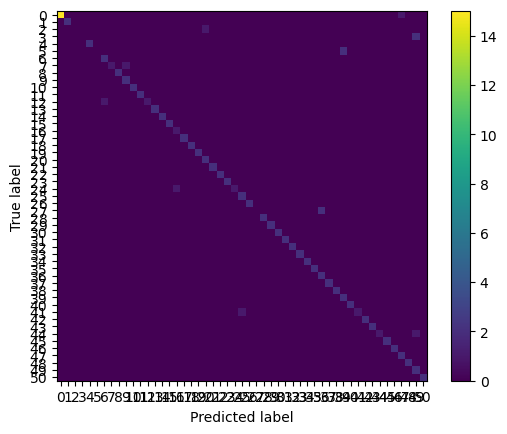

In [33]:
plt.figure(figsize=(10,20))
cnfusion.plot(include_values=False)

In [36]:
test_df["Label"].values

array(['nothing', 'nothing', 'nothing', ..., 'nothing', 'nothing',
       'nothing'], dtype=object)

In [33]:
import glob
import os



test_df = pd.read_csv(rf"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\20250715_111750_DATA_INDICATOR_sensor.csv")
# test_df  = test_df[test_df.columns[1:]]
test_dataset = CustomDataset("collect_data/20250624_131408_พชชาภา24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=chunk,table=True,dataframe=test_df)
test_dataset = DataLoader(test_dataset,batch_size=1)

y_pred1 = []
y_true1 = []
prob_x = []
prob_y = []
with torch.no_grad():
    for inputs2,answer in tqdm(test_dataset):
        output = model(inputs2)
        prob_x.append(output)
        prob_y.append(answer)
        y_pred1 += (torch.argmax(output,dim=1)).tolist()
        # y_true1 += (torch.argmax(answer,dim=0)).tolist()
        y_true1 += [answer.item()]
            
          
from sklearn.metrics import f1_score,recall_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
f1_scores = f1_score(y_true1, y_pred1, average="micro")
print("f1 score    ",f1_scores)
recall_scores = recall_score(y_true1, y_pred1, average="micro")
print("recal score ",recall_scores)
acc = accuracy_score(y_true1, y_pred1)
print("acc score   ",acc)
# cnf = confusion_matrix(y_true, y_pred)  

NameError: name 'CustomDataset' is not defined

# How to use Model

In [50]:
def convert_data_csv_train(data,segment=50):

    real = []
    for i in tqdm(data,total = len(data)):
        segment = segment
        if len(i) < segment:
            # tensor_df = (torch.tensor(i.clone()))
            tensor_df = i.clone()
            n,b = tensor_df.size()
            padded_tensor = torch.nn.functional.pad(tensor_df, pad=(0, 0, segment-n, 0), mode='constant', value=0)
            # print(padded_tensor.size())
            real.append(padded_tensor.tolist())
        else:
            step = int(np.ceil(len(i)//segment))
            temp = []
            for k in range(segment):
                temp.append(torch.mean(torch.tensor(i[k*step:(k+1)*step]),dim=0).tolist())
            real.append(temp)
    return torch.tensor(real)

In [75]:
model = torch.load(r"./model/Version1/finalmodel.pt",weights_only=False)
with open(r"rollback.json",'r') as f:
    vocap = json.load(f)

In [81]:
base_df = pd.DataFrame()
for i in glob.glob(r"./collect_data/new_data/*"):
    df = pd.read_csv(rf"{i}")
    base_df = pd.concat([base_df,df])
    break
print(len(base_df))

11982


In [248]:
md = torch.load(r"F:\Hybridmodel-project\Sign_Language_Detection\model\finalmodel_86.pt",weights_only=False)

In [250]:
md.eval()

CNNTimeSeriesClassifier(
  (normalization): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=51, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
data = torch.rand(1,29)
datas = torch.rand(1,29)
i=0
while i<20:
    
    ### you need to put a streaming inout here
    
    
    datas = torch.concat([datas,data])
    i+=1
    
    
    
datas = datas[1:,:]

### input must be [chunk,feature] --> [x,29]
tas = convert_data_csv_train(datas.unsqueeze(0))
tas = tas.movedim(1,2)
answer = torch.argmax(model(tas))
finalans = vocap[str(answer.item())]

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import torch
import numpy as np
chunk_size = 50
features = torch.rand(30,28)
sequences = []
if len(features) >= 50:
    # If longer than chunk_size, use uniform sampling
    indices = np.linspace(0, len(features)-1, chunk_size, dtype=int)
    sequence = features[indices]
else:
    # If shorter, pad with zeros at the end
    sequence = np.zeros((chunk_size, features.shape[1]))
    sequence[:len(features)] = features

sequences.append(sequence)
# labels.append(most_common_label)

In [10]:
sequences[0].shape

(50, 28)

In [13]:
model = torch.load(r"F:\Hybridmodel-project\Sign_Language_Detection\model\cnn_timeseries_model_20250803_120029.pth",weights_only=False)


c:\Users\wayupuk sommuang\aida\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
model

{'model_state_dict': OrderedDict([('normalization.weight',
               tensor([0.9368, 1.0048, 0.9357, 0.9360, 1.0072, 0.9416, 0.8587, 0.8866, 0.9098,
                       0.9012, 0.9464, 0.9348, 0.7739, 0.6852, 1.0935, 0.9764, 1.0977, 1.1291,
                       1.2618, 1.2244, 0.9526, 1.0216, 0.8541, 1.0645, 1.0574, 1.0971, 1.0129,
                       1.2894], device='cuda:0')),
              ('normalization.bias',
               tensor([-0.0565, -0.0850, -0.1522, -0.0644, -0.0521,  0.0517, -0.0049,  0.0787,
                        0.1080,  0.0714, -0.0971,  0.0076,  0.0657, -0.0166,  0.0871,  0.0297,
                       -0.1515, -0.1185, -0.0374,  0.1313,  0.1707,  0.0885,  0.0428,  0.1231,
                       -0.0491, -0.0695, -0.0235, -0.0912], device='cuda:0')),
              ('normalization.running_mean',
               tensor([-6.7445e-01, -6.0989e+00, -5.3089e+00, -2.3383e-02,  3.4808e-02,
                       -1.6581e-02, -4.0500e+01, -4.7012e+00,  1.2256e+

In [30]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
from scipy import signal
import os
from collections import Counter
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
# os.environ["MP_DUPLICATE_LIB_OK"] = "True"

class CNNTimeSeriesClassifier(nn.Module):
    def __init__(self, input_shape, n_classes, dropout=0.3):
        """
        CNN-based Time Series Classifier following your architecture diagram
        
        Args:
            input_shape: Tuple (sequence_length, n_features) - e.g., (121, 21)
            n_classes: Number of output classes
            dropout: Dropout rate
        """
        super(CNNTimeSeriesClassifier, self).__init__()
        
        seq_len, n_features = input_shape
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.dropout_rate = dropout
        
        # Input normalization layer
        self.normalization = nn.BatchNorm1d(n_features)
        
        # Reshape for 2D convolution: (batch, channels, height, width)
        # We'll treat sequence as height and features as width, with 1 channel
        # Input shape: (None, 1, seq_len, n_features) - e.g., (None, 1, 121, 21)
        # First Conv2D block
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after first conv+pool
        # After conv1: (None, 32, 121, 21) -> (None, 32, 119, 19) with padding=1
        # After pool1: (None, 32, 119, 19) -> (None, 32, 59, 9)
        h1, w1 = seq_len // 2, n_features // 2
        
        # Second Conv2D block
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Calculate shape after second conv+pool
        # After conv2: (None, 64, 59, 9) -> (None, 64, 57, 7) with padding=1
        # After pool2: (None, 64, 57, 7) -> (None, 64, 28, 3)
        h2, w2 = h1 // 2, w1 // 2
        
        # Third Conv2D block
        self.conv3 = nn.Conv2d(
            in_channels=64, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding=1
        )
        
        # Calculate final conv output shape
        # After conv3: (None, 64, 28, 3) -> (None, 64, 26, 1) with padding=1
        h3, w3 = h2, w2
        
        # Calculate flattened size dynamically
        self.flatten_size = 64 * h3 * w3
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, n_classes)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights properly"""
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        # Input shape: (batch_size, seq_len, n_features)
        batch_size = x.size(0)
        
        # Normalize along feature dimension
        # Reshape for BatchNorm1d: (batch_size * seq_len, n_features)
        x_norm = x.view(-1, x.size(2))
        # print(x_norm)
        # ([print(i.dtype) for i in x_norm])
        x_norm = self.normalization(x_norm)
        x = x_norm.view(batch_size, x.size(1), x.size(2))
        
        # Reshape for 2D convolution: (batch_size, 1, seq_len, n_features)
        x = x.unsqueeze(1)
        
        # First Conv2D + MaxPool2D
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Conv2D + MaxPool2D
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Third Conv2D
        x = self.conv3(x)
        x = self.relu(x)
        
        # Flatten
        x = x.view(batch_size, -1)
        
        # First Dense layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second Dense layer (output)
        x = self.fc2(x)
        
        return x
    
    def get_config(self):
        """Return model configuration for saving"""
        return {
            'input_shape': self.input_shape,
            'n_classes': self.n_classes,
            'dropout': self.dropout_rate,
            'flatten_size': self.flatten_size
        }
# dicta = torch.load(r"F:\Hybridmodel-project\Sign_Language_Detection\model\cnn_timeseries_model_20250803_120029.pth",weights_only=False)




def convert_data(features):
    chunk_size = 50
    # features = torch.rand(30,28)
    # sequences = []
    if len(features) >= 50:
        # If longer than chunk_size, use uniform sampling
        indices = np.linspace(0, len(features)-1, chunk_size, dtype=int)
        sequence = features[indices]
    else:
        # If shorter, pad with zeros at the end
        sequence = np.zeros((chunk_size, features.shape[1]))
        sequence[:len(features)] = features

    
    if torch.cuda.is_available():
        return torch.from_numpy(sequence).to("cuda")
    else:
        return torch.from_numpy(sequence)
    

model_path = "F:\Hybridmodel-project\Sign_Language_Detection\model\model_96.pt"
if torch.cuda.is_available():
    model = torch.load(rf"{model_path}",weights_only=False)
    
    model.to("cuda")
else:
    model = torch.load(rf"{model_path}",weights_only=False,map_location=torch.device('cpu'))
    
    # model
model.double()
model.eval()
datas = torch.rand(1,28).double()

data = torch.rand(1,28).double()
i = 0
while i<20:

    datas = torch.concat([datas,data])
    i+=1
    
    
print(datas.dtype)
tas = convert_data(datas)
# print("ashj",tas.dtype)
answer = torch.argmax(model(tas.unsqueeze(0)))
print(answer)
# finalans = vocap[str(answer.item())]

torch.float64
tensor(21, device='cuda:0')


In [31]:
tas

tensor([[0.2792, 0.5052, 0.1211,  ..., 0.3130, 0.2965, 0.4513],
        [0.8418, 0.7954, 0.3356,  ..., 0.8429, 0.9458, 0.6651],
        [0.8418, 0.7954, 0.3356,  ..., 0.8429, 0.9458, 0.6651],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', dtype=torch.float64)